In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [2]:
tweets = []
files = ['LabeledData1.json', 'LabeledData2.json', 'LabeledData3.json']
for file in files:
    with open (file, 'r', encoding="utf8") as f:
        tweets += f.readlines()

with open('classify.json', 'w') as f:
    for tweet in tweets:
        f.write(tweet)

In [3]:
# create a dataframe to store the information
df = pd.DataFrame(columns=['text', 'relevant'])

handle = open('classify.json')

for line in handle:
    item = json.loads(line)
    if item['isRelevant'] == 0:
        temp = pd.DataFrame([[item['text'], 'notRelevant']], columns=['text', 'relevant'])
    else:
        temp = pd.DataFrame([[item['text'], 'relevant']], columns=['text', 'relevant'])
    df = df.append(temp, ignore_index=True)
    
handle.close()

print(df.head())

                                                text     relevant
0  @lileeny @elonmusk Those are destination charg...     relevant
1  @SpaceX @elonmusk thanks for making fricking S...  notRelevant
2  @InsideEVs Tesla Super chargers working hard t...     relevant
3  Egyptian musk, bitches blush, a vintage tux, t...  notRelevant
4  Angels in Heaven), silk bedding filled with mu...  notRelevant


In [4]:
le = preprocessing.LabelEncoder()
le.fit(df['relevant'])
labels = le.transform(df['relevant']) 
df['relevant'] = labels

print(df.head())

                                                text  relevant
0  @lileeny @elonmusk Those are destination charg...         1
1  @SpaceX @elonmusk thanks for making fricking S...         0
2  @InsideEVs Tesla Super chargers working hard t...         1
3  Egyptian musk, bitches blush, a vintage tux, t...         0
4  Angels in Heaven), silk bedding filled with mu...         0


In [5]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def calcScores(y, pred):
    averageType = "binary"
    accuracy = accuracy_score(y, pred)
    print("Accuracy: %0.4f" % (accuracy))
    recall = recall_score(y, pred, average=averageType)
    print("Recall: %0.4f" % recall)
    precision = precision_score(y, pred, average=averageType)
    print("Precision: %0.4f" % precision)
    f1 = f1_score(y, pred, average=averageType)
    print("F-Score: %0.4f" % f1)
    return accuracy, recall, precision, f1



In [7]:
##split data
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['relevant'], test_size=0.25)

##Naive Bayes
text_clf_pipe_nb = Pipeline([('vect', StemmedCountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('mnb', MultinomialNB(fit_prior=False)),])

text_clf_nb = text_clf_pipe_nb.fit(x_train, y_train)
train_pred_nb = text_clf_nb.predict(x_train)
test_pred_nb = text_clf_nb.predict(x_test)

print("-----Naive Bayes-----")
print("Train")
values_train_nb = calcScores(y_train, train_pred_nb)
print("\nTest")
values_test_nb = calcScores(y_test, test_pred_nb)

##SVM
from sklearn.linear_model import SGDClassifier
text_clf_pipe_svm = Pipeline([('vect', StemmedCountVectorizer(stop_words='english')),
                              ('tfidf', TfidfTransformer()),
                              ('clf-svm', SGDClassifier(loss='hinge', 
                                                        penalty='l2', alpha=1e-3, 
                                                        max_iter=5, tol=None, 
                                                        random_state=42))])
text_clf_svm = text_clf_pipe_svm.fit(x_train, y_train)
train_pred_svm = text_clf_svm.predict(x_train)
test_pred_svm = text_clf_svm.predict(x_test)

print("\n-----SVM-----")
print("Train")
values_train_svm = calcScores(y_train, train_pred_svm)
print("\nTest")
values_test_svm = calcScores(y_test, test_pred_svm)

-----Naive Bayes-----
Train
Accuracy: 0.9352
Recall: 0.9600
Precision: 0.8956
F-Score: 0.9267

Test
Accuracy: 0.7763
Recall: 0.8155
Precision: 0.7227
F-Score: 0.7663

-----SVM-----
Train
Accuracy: 0.8849
Recall: 0.8984
Precision: 0.8422
F-Score: 0.8694

Test
Accuracy: 0.8455
Recall: 0.8663
Precision: 0.8050
F-Score: 0.8345


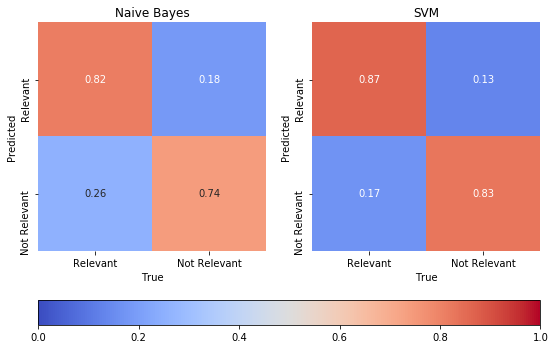

In [9]:
##plot confusion matrices
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def normalizeCM(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm

def createCmDf(cm):
    df_cm = pd.DataFrame(cm, index = ["Relevant", "Not Relevant"], columns = ["Relevant", "Not Relevant"])
    return df_cm
cm_nb = confusion_matrix(y_test,test_pred_nb, labels = [1, 0])
cm_nb = normalizeCM(cm_nb)

cm_svm = confusion_matrix(y_test,test_pred_svm, labels = [1, 0])
cm_svm = normalizeCM(cm_svm)

df_nb = createCmDf(cm_nb)
df_svm = createCmDf(cm_svm)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(9, 6))
im = sn.heatmap(df_nb, ax=ax1, annot=True, vmin=0, vmax=1, cmap='coolwarm', cbar = False)
ax1.set_title("Naive Bayes")
ax1.set_xlabel("True")
ax1.set_ylabel("Predicted")
sn.heatmap(df_svm, ax=ax2, annot=True, vmin=0, vmax=1, cmap='coolwarm', cbar = False)
ax2.set_title("SVM")
ax2.set_xlabel("True")
ax2.set_ylabel("Predicted")
mappable = im.get_children()[0]
plt.colorbar(mappable, ax = [ax1,ax2],orientation = 'horizontal')
plt.show()